## Partitionner les vidéos

**But :** Partitionner les vidéos par séquences de comportement pour avoir une vidéo par comportement étiqueté.

Organisation :
* videos de 30 sec
* fichier format csv regroupant les times codes et labels pour chaque vidéo

| Date | Molecule | Concentration | T | N° vidéo | Label | Start (s) | End (s) | Se tortille (Oui), ne se tortille pas (non) |
|:----------:|:--------:|:------------:|:----------:|:--------:|:------------:|:----------:|:--------:|:------------:|

In [23]:
from os import listdir
from os.path import isfile
from pathlib import Path

import cv2

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

### Définition des fichiers et répertoires de travail

In [2]:
folder_path = "../data/videos/labelised"
label_file_path = f"{folder_path}/Labelisation_L-glutamate_12-04-22_LR.csv"

### Charger le fichier de labelisation

In [3]:
def load_file(file_path):
    columns_names = ['date','molecule','concentration','temps','num','label','start','end','tortille']
    label_file = pd.read_csv(file_path, header = 0, names=columns_names)

    label_file = label_file.replace(to_replace='OUI', value=1)
    label_file = label_file.replace(to_replace='NON', value=0)

    # rajouter un '0' devant le num pour coller au nom des vidéos
    label_file['num'] = '0' + label_file['num'].astype(str)

    # enlever la majuscule du nom de la molecule non présente dans le nom des vidéos
    label_file = label_file.replace(to_replace='L-Glutamate', value='L-glutamate')

    return label_file

In [4]:
label_file = load_file(label_file_path)

label_file

,date,molecule,concentration,temps,num,label,start,end,tortille
0,12-04-2022,L-glutamate,0,T0,01,Wildtype,00:02,00:30,0
1,12-04-2022,L-glutamate,0,T0,02,Wildtype,00:00,00:30,0
2,12-04-2022,L-glutamate,0,T0,03,Wildtype,00:00,00:07,0
3,12-04-2022,L-glutamate,0,T0,03,Screw-like,00:08,00:14,1
4,12-04-2022,L-glutamate,0,T0,03,Wildtype,00:14,00:30,0
...,...,...,...,...,...,...,...,...,...
73,12-04-2022,L-glutamate,10,T15,03,Bridge-like,00:12,00:23,0
74,12-04-2022,L-glutamate,10,T15,03,Screw-like,00:24,00:30,1
75,12-04-2022,L-glutamate,10,T15,05,Screw-like,00:00,00:30,1
76,12-04-2022,L-glutamate,10,T15,07,Screw-like,00:00,00:19,1


### Extraction des différents comportements par vidéos

Le nom de chaque vidéo est la concatéation  de *date_molecule_concentration_temps_num*

In [4]:
import os

# Remplace les espaces dans le nom des vidéos par '_'
def rename_videos(folder_path):
    videos = [v for v in listdir(folder_path) if v.count('.csv') == 0]
    
    for video  in videos:
        if video.count(' ') > 0:
            os.rename(f"{folder_path}/{video}",f"{folder_path}/{video.replace(' ','_')}")
            
rename_videos(folder_path)

Etape préli : Créer un dossier *labels* puis un sous dossier par label référencés dans le csv

Pour chaque ligne dans le df
* récupérer le nom de la vidéo en concatenant
* récupérer le label assigné
* récupérer le time code de début et fin
* créer un dossier par vidéo
* split la vidéo selon tc et save dans labels/label_assigne et dans le dossier de la vidéo



In [5]:
def create_labels_folders(folder_path, label_file):
    labels = list(set(label_file['label']))
    
    Path(f"{folder_path}/labels").mkdir(parents=True, exist_ok=True)
    for label in labels:
        Path(f"{folder_path}/labels/{label}").mkdir(parents=True, exist_ok=True)

In [6]:
def video_to_frames(video_name, video_path, timecode, tortille, outputs):
    # on commence par créer les différents dossiers
    for out in outputs:
        Path(out).mkdir(parents=True, exist_ok=True)
    
    tortille_folder = outputs.pop(-1)
    Path(f"{tortille_folder}/oui").mkdir(parents=True, exist_ok=True)
    Path(f"{tortille_folder}/non").mkdir(parents=True, exist_ok=True)

    start, end = timecode
    f = 0
    vidcap = cv2.VideoCapture(video_path)
    print(video_path)
    if vidcap.isOpened():
        print('video opened')
        success,image = vidcap.read()
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(f*1000))
            success,image = vidcap.read()
            if success and f >= start and f <= end:
                for out in outputs:
                    cv2.imwrite( f"{out}/{video_name}_frame{f}.jpg", image)
                if tortille:
                    cv2.imwrite( f"{tortille_folder}/oui/{video_name}_frame{f}.jpg", image)
                else:
                    cv2.imwrite( f"{tortille_folder}/non/{video_name}_frame{f}.jpg", image)
            elif success:
                # dans tous les cas on save l'image dans all
                cv2.imwrite( f"{outputs[-1]}/{video_name}_frame{f}.jpg", image)
            f += 1
        print('successfully saved')
    
    else:
        print('failed to open')

In [7]:
def extract_data(folder_path, label_file):

    create_labels_folders(folder_path, label_file)
    labels_path = f"{folder_path}/labels"
    
    for index, row in label_file.iterrows():
        video_name = f"{row['date'].replace('2022','22')}_{row['molecule']}_{row['concentration']}_{row['temps']}_{row['num']}"
        video_path = f"{folder_path}/{video_name}.avi"
        label = row['label']
        tortille = row['tortille']
        timecode = (int(row['start'][3:]),int(row['end'][3:]))

        # les différents repertoires où save les images
        outputs = [f"{video_path[:-4]}/{label}",
                   f"{labels_path}/{label}",
                   f"{folder_path}/all",
                   f"{folder_path}/tortille"]

        video_to_frames(video_name, video_path, timecode, tortille, outputs)

In [8]:
extract_data(folder_path, label_file)

data/videos/labelised/12-04-22_L-glutamate_0_T0_01.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_02.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_03.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_03.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_03.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_04.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_05.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_06.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_07.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_08.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_0_T0_01.avi
video opened
successfully saved
data/videos/labelised/12-04-22_L-glutamate_

### Visualisation des images extraites

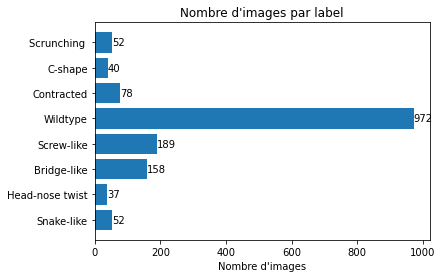

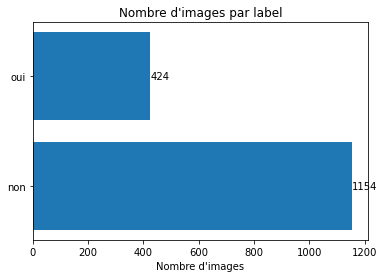

In [34]:
def images_count(folder):
    labels = listdir(folder)
    count = []

    for label in labels:
        imgs = listdir(f"{folder}/{label}")
        count.append(len(imgs))
    
    fig, ax = plt.subplots()
    y_pos = np.arange(len(labels))

    ax.barh(y_pos, count)
    for bars in ax.containers:
        ax.bar_label(bars)
    ax.set_yticks(y_pos, labels=labels)
    ax.invert_yaxis()
    ax.set_xlabel('Nombre d\'images')
    ax.set_title('Nombre d\'images par label')

    plt.show()



images_count(f"{folder_path}/labels")
images_count(f"{folder_path}/tortille")